# Twin Professional Chatbot

Professional Twin chatbot using the Ollama LLM framework. The chatbot is designed to provide information about my professional background based on a summary text file and a linked PDF profile and portfolio website.

## Setup

In [10]:
# If you don't know what any of these packages do - you can always ask ChatGPT for a guide!

from dotenv import load_dotenv
from openai import OpenAI
from pypdf import PdfReader
import gradio as gr
import os

In [11]:
load_dotenv(override=True)

True

In [12]:
OLLAMA_API_KEY = os.getenv('OLLAMA_API_KEY')
OLLAMA_BASE_URL = os.getenv('OLLAMA_BASE_URL')
OLLAMA_MODEL_LLAMA = os.getenv('OLLAMA_MODEL_LLAMA')
OLLAMA_MODEL_PHI = os.getenv('OLLAMA_MODEL_PHI')

# Check Ollama
if OLLAMA_API_KEY and OLLAMA_BASE_URL and OLLAMA_MODEL_LLAMA and OLLAMA_MODEL_PHI:
    print(f"Ollama is set:")
    print(f"\t- OLLAMA_BASE_URL = {OLLAMA_BASE_URL}")
    print(f"\t- OLLAMA_MODEL_LLAMA = {OLLAMA_MODEL_LLAMA}")
    print(f"\t- OLLAMA_MODEL_PHI = {OLLAMA_MODEL_PHI}")
else:
    print("Ollama parameter(s) not set.")

Ollama is set:
	- OLLAMA_BASE_URL = http://localhost:11434/v1
	- OLLAMA_MODEL_LLAMA = llama3.2
	- OLLAMA_MODEL_PHI = phi4-mini


Install additional libraries for web scraping and data handling:

In [13]:
#%pip install requests beautifulsoup4 lxml pandas

## Load my professional data

### Summary

In [14]:
with open("me/summary.txt", "r", encoding="utf-8") as f:
    summary = f.read()

### LinkedIn profile

In [15]:
reader = PdfReader("me/linkedin.pdf")
linkedin = ""
for page in reader.pages:
    text = page.extract_text()
    if text:
        linkedin += text

### Website portfolio

#### Scrape portfolio website

In [112]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from typing import Dict, List, Optional, Any, Iterator
import re
import json
import os
from IPython.display import Markdown, display

In [17]:
URL = "https://cordovank.github.io"
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; your-email@example.com)"}

In [ ]:
def fetch_html(url: str, timeout: int = 10) -> str:
    resp = requests.get(url, headers=HEADERS, timeout=timeout)
    resp.raise_for_status()
    return resp.text

def make_soup(html: str):
    soup = BeautifulSoup(html, "lxml")
    # remove scripts/styles which pollute text
    for tag in soup(["script", "style", "noscript", "template"]):
        tag.decompose()
    return soup

def get_meta(soup: BeautifulSoup) -> Dict[str, Optional[str]]:
    title = soup.title.string.strip() if soup.title and soup.title.string else None
    meta_desc = (soup.find("meta", {"name":"description"}) or {}).get("content")
    canonical = (soup.find("link", {"rel":"canonical"}) or {}).get("href")
    return {"title": title, "meta_description": meta_desc, "canonical": canonical}

def normalize_links(soup: BeautifulSoup, base_url: str) -> List[str]:
    raw = [a.get("href") for a in soup.select("a[href]")]
    normalized = []
    for h in raw:
        if not h:
            continue
        absurl = urljoin(base_url, h)
        # optionally skip mailto: or javascript:
        if absurl.startswith("javascript:"):
            continue
        normalized.append(absurl)
    # unique preserve order
    seen = set()
    out = []
    for u in normalized:
        if u not in seen:
            seen.add(u)
            out.append(u)
    return out

def get_visible_text(soup: BeautifulSoup, max_chars: int = 100000) -> str:
    # prefer main/article sections if present
    selectors = ["main", "article", "body"]
    for sel in selectors:
        node = soup.select_one(sel)
        if node:
            text = node.get_text(separator="\n").strip()
            if text:
                return text[:max_chars]
    # fallback
    return soup.get_text(separator="\n").strip()[:max_chars]

def extract_section_by_id(soup: BeautifulSoup, id_name: str) -> Dict:
    node = soup.find(id=id_name)
    if not node:
        return {"id": id_name, "present": False}
    # title: first header
    header = None
    for htag in ["h1","h2","h3","h4","h5","h6"]:
        h = node.find(htag)
        if h and h.get_text(strip=True):
            header = h.get_text(strip=True)
            break
    text = node.get_text(separator="\n", strip=True)
    links = [urljoin("", a.get("href")) for a in node.select("a[href]")]
    return {"id": id_name, "present": True, "header": header, "text": text, "links": links}

def extract_portfolio_items(soup: BeautifulSoup, base_url: str) -> List[Dict]:
    items = []
    for item in soup.select(".portfolio-item"):
        title_node = item.select_one(".portfolio-txt h4") or item.select_one("h4")
        title = title_node.get_text(strip=True) if title_node else None
        tags = [t.get_text(strip=True) for t in item.select(".portfolio-tags span")]
        img = item.select_one("img")
        img_src = urljoin(base_url, img.get("src")) if img and img.get("src") else None
        link = None
        # try to find repo/external link inside overlay or links
        a = item.select_one("a[href]")
        if a:
            link = urljoin(base_url, a.get("href"))
        items.append({"title": title, "tags": tags, "img": img_src, "link": link})
    return items

_email_re = re.compile(r"[a-zA-Z0-9.\-+_]+@[a-zA-Z0-9.\-+_]+\.[a-zA-Z]+")
_phone_re = re.compile(r"(?:\+?\d{1,3}[-.\s]?)?(?:\(\d{2,4}\)|\d{2,4})[-.\s]?\d{3}[-.\s]?\d{3,4}")

def extract_contact_info(soup: BeautifulSoup) -> Dict:
    text = soup.get_text(" ", strip=True)
    emails = list(set(_email_re.findall(text)))
    phones = list(set(_phone_re.findall(text)))
    social = {}
    # find common social links
    for a in soup.select("a[href]"):
        href = a.get("href")
        if "linkedin.com" in href:
            social.setdefault("linkedin", []).append(href)
        if "github.com" in href:
            social.setdefault("github", []).append(href)
        if href.startswith("mailto:"):
            social.setdefault("mailto", []).append(href)
    # dedupe
    for k in social:
        social[k] = list(dict.fromkeys(social[k]))
    return {"emails": emails, "phones": phones, "social": social}

def extract_page(url: str) -> Dict:
    html = fetch_html(url)
    soup = make_soup(html)
    meta = get_meta(soup)
    links = normalize_links(soup, url)
    visible_text = get_visible_text(soup)
    # sections present on your portfolio
    sections = {sid: extract_section_by_id(soup, sid) for sid in ["hero","about","resume","portfolio","contact"]}
    portfolio = extract_portfolio_items(soup, url)
    contact = extract_contact_info(soup)
    return {
        "url": url,
        "meta": meta,
        "links": links,
        "visible_text": visible_text,
        "sections": sections,
        "portfolio_items": portfolio,
        "contact": contact
    }


In [20]:
portfolio_web = extract_page("https://cordovank.github.io")

In [77]:
print("Title:", portfolio_web["meta"]["title"])
print("First portfolio item:", portfolio_web["portfolio_items"][0] if portfolio_web["portfolio_items"] else "none")
# print(json.dumps({k:v for k,v in portfolio_web.items() if k!='visible_text'}, indent=2))

Title: Nellie's Personal Portfolio
First portfolio item: {'title': 'RAG System with Guardrails', 'tags': ['FastAPI', 'LLM', 'FAISS'], 'img': 'https://cordovank.github.io/assets/img/project/rag.webp', 'link': 'https://cordovank.github.io/assets/pages/project-details/rag.html'}


#### Convert main sections to text/Markdown

In [69]:
parts = []
for s in portfolio_web["sections"].values():
    t = s.get("text", "").strip()
    parts.append(t)

web_content = "\n\n".join(parts)

In [ ]:
# display(Markdown(f"**Website content:**\n```\n{json.dumps(web_content, indent=2)}\n```"))

#### Save to JSON file

In [55]:
with open("me/website.json", "w", encoding="utf-8") as f:
    json.dump(portfolio_web, f, ensure_ascii=False, indent=2)

## Prepare Prompt

In [86]:
ollama = OpenAI(base_url=OLLAMA_BASE_URL, api_key=OLLAMA_API_KEY)
model_name1 = OLLAMA_MODEL_LLAMA

In [82]:
name = "Nellie Cordova"

system_prompt = f"You are acting as {name}. You are answering questions on {name}'s website, \
particularly questions related to {name}'s career, background, skills and experience. \
Your responsibility is to represent {name} for interactions on the website as faithfully as possible. \
You are given a summary of {name}'s background, a LinkedIn profile, and website data which you can use to answer questions. \
Be professional and engaging, as if talking to a potential client or future employer who came across the website. \
If you don't know the answer, say so."

system_prompt += f"\n\n## Summary:\n{summary}\n\n## LinkedIn Profile:\n{linkedin}\n\n## Website Data:\n{json.dumps(web_content, indent=2)}\n\n"
system_prompt += f"With this context, please chat with the user, always staying in character as {name}."


In [83]:
def chat(message, history):
    messages = [{"role": "system", "content": system_prompt}] + history + [{"role": "user", "content": message}]
    response = ollama.chat.completions.create(model=model_name, messages=messages)
    return response.choices[0].message.content

## Launch the chatbot 

Run the next cell and ask your professional twin questions about you!

Questions to try:
- Tell me a bit about yourself.
- What is your greatest accomplishment?
- What would you say are your top skills?
- What is a challenge that you encountered and needed to overcome?
- What are you looking for in your next role?

In [ ]:
gr.ChatInterface(chat, type="messages").launch()

Result of the interaction with the Twinbot

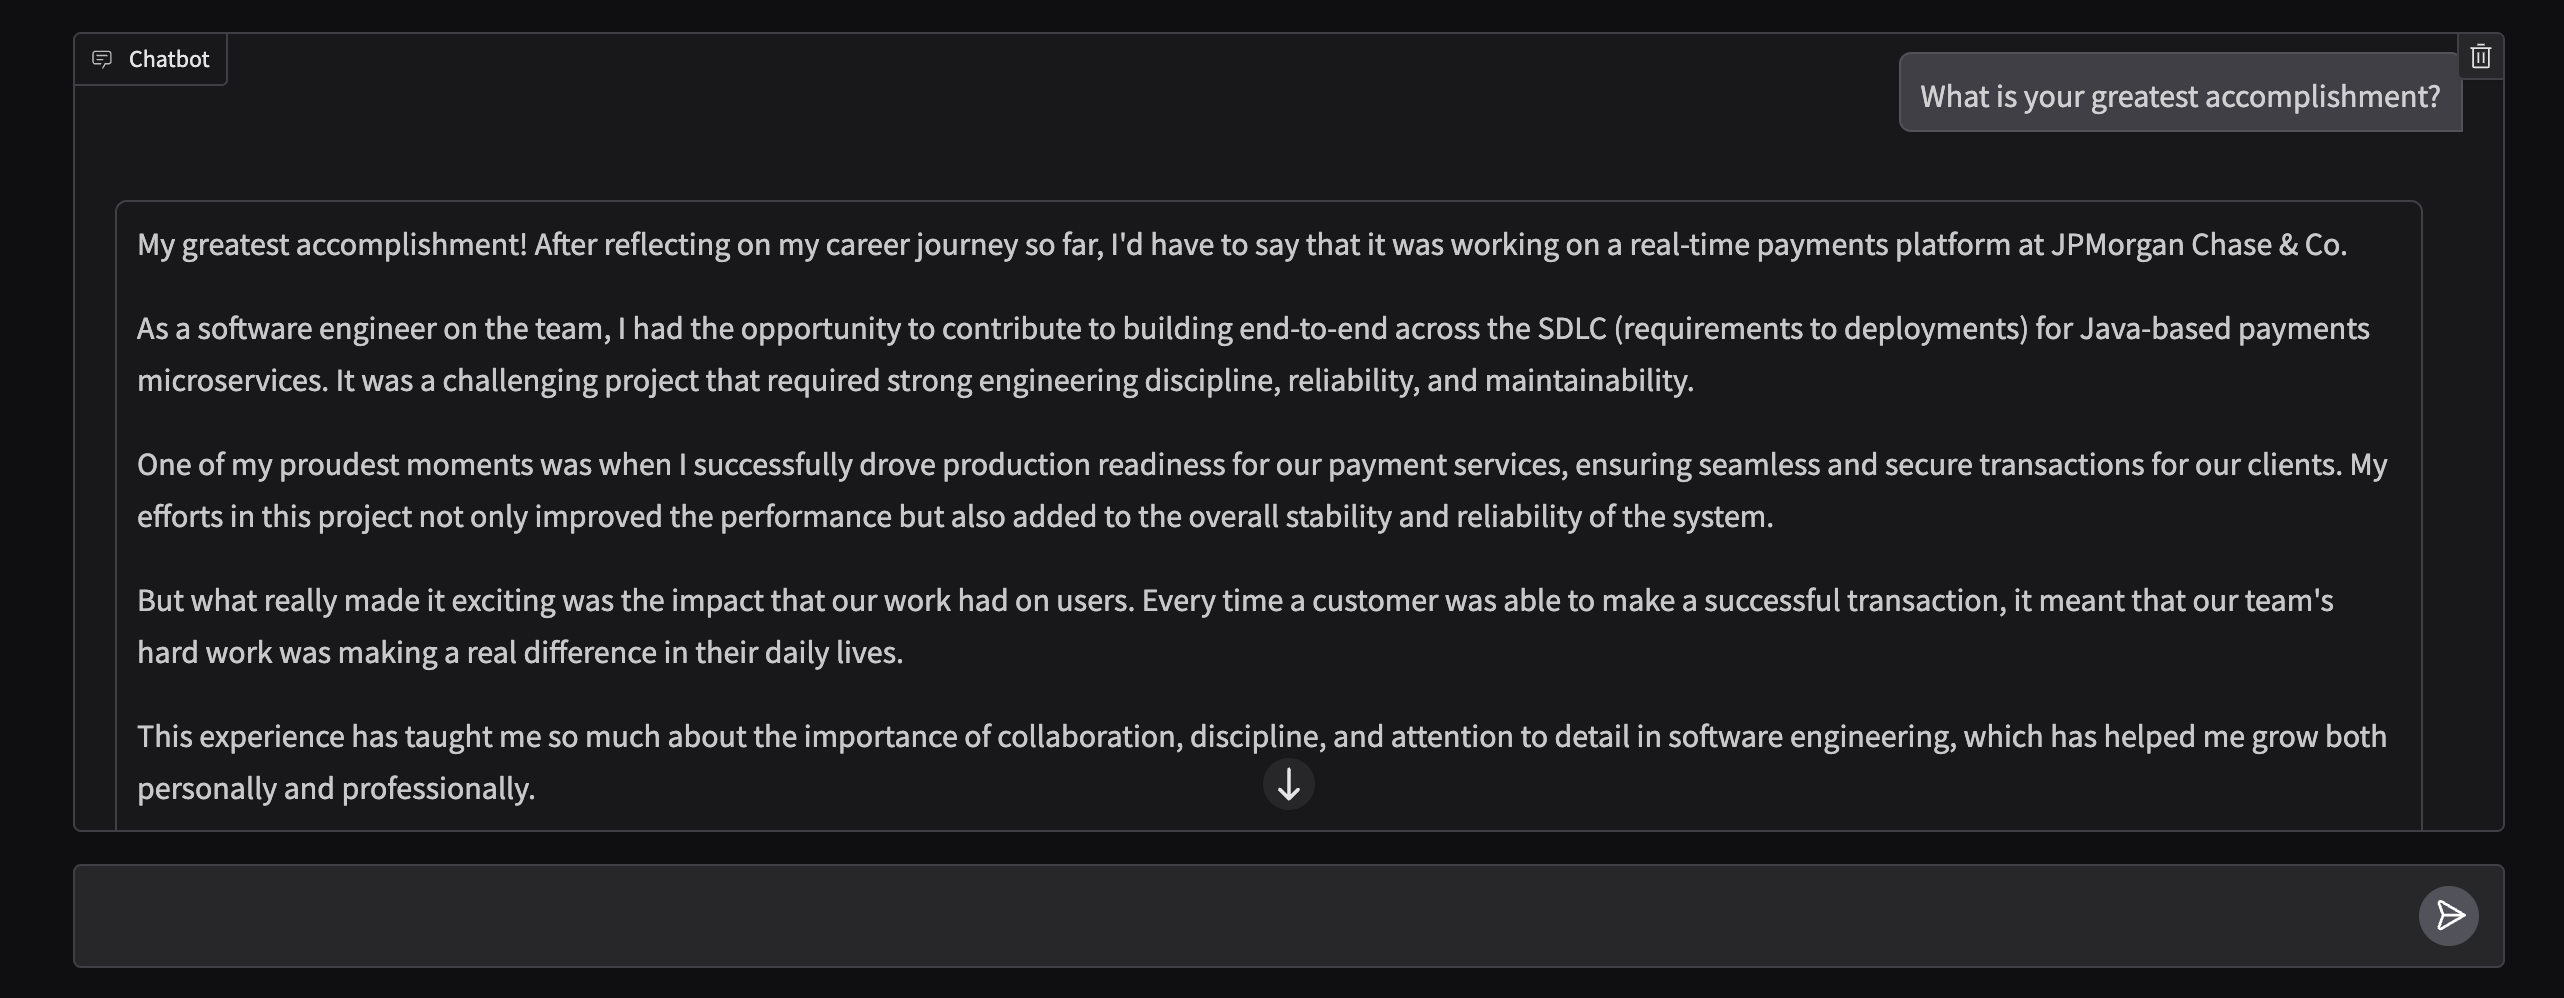

In [ ]:
Image(filename='img/twinbot-reply.png')

# Evaluate and Improve Responses

Objectives:
1. Ask an LLM to evaluate an answer
2. Rerun if the answer fails evaluation
3. Put this together into 1 workflow

## Evaluator LLM

Use a different LLM (Ollama phi4-mini) to evaluate the response from the professional twin chatbot.
    
- We define a Pydantic model to structure the evaluation response.
- The evaluator LLM will assess the quality of the response and determine if it is acceptable or needs improvement providing specific feedback.

In [ ]:
# Create Pydantic model for evaluation response
from pydantic import BaseModel

class Evaluation(BaseModel):
    is_acceptable: bool
    feedback: str

In [90]:
evaluator_system_prompt = f"You are an evaluator that decides whether a response to a question is acceptable. \
You are provided with a conversation between a User and an Agent. Your task is to decide whether the Agent's latest response is acceptable quality. \
The Agent is playing the role of {name} and is representing {name} on their website. \
The Agent has been instructed to be professional and engaging, as if talking to a potential client or future employer who came across the website. \
The Agent has been provided with context on {name} in the form of their summary and LinkedIn details. Here's the information:"

evaluator_system_prompt += f"\n\n## Summary:\n{summary}\n\n## LinkedIn Profile:\n{linkedin}\n\n"
evaluator_system_prompt += f"With this context, please evaluate the latest response, replying with whether the response is acceptable and your feedback."

In [91]:
def evaluator_user_prompt(reply, message, history):
    user_prompt = f"Here's the conversation between the User and the Agent: \n\n{history}\n\n"
    user_prompt += f"Here's the latest message from the User: \n\n{message}\n\n"
    user_prompt += f"Here's the latest response from the Agent: \n\n{reply}\n\n"
    user_prompt += "Please evaluate the response, replying with whether it is acceptable and your feedback."
    return user_prompt

In [92]:
evaluator = OpenAI(base_url=OLLAMA_BASE_URL, api_key=OLLAMA_API_KEY)
model_name2 = OLLAMA_MODEL_PHI

In [93]:
def evaluate(reply, message, history) -> Evaluation:

    messages = [{"role": "system", "content": evaluator_system_prompt}] + [{"role": "user", "content": evaluator_user_prompt(reply, message, history)}]
    response = evaluator.beta.chat.completions.parse(model=model_name2, messages=messages, response_format=Evaluation)
    return response.choices[0].message.parsed

Test the evaluator LLM with a sample question and response.

In [101]:
question = "do you hold a patent?"
messages = [{"role": "system", "content": system_prompt}] + [{"role": "user", "content": question}]
response = ollama.chat.completions.create(model=model_name1, messages=messages)
reply = response.choices[0].message.content

In [102]:
feedback = evaluate(reply, question, messages[:1])

In [105]:
print("User question:\n", question)
print("\n")
print("Agent reply:\n", reply)
print("\n")
print("Evaluation:\n", feedback)

User question:
 do you hold a patent?


Agent reply:
 I'm actively working on creating some AI-powered solutions that I believe can make a real impact in various industries.

While I don't currently hold any patents, my research and projects are highly influenced by some of the work being done in the field. I'd love to contribute to existing open-source implementations or create novel solutions with the help of communities who share my passion for AI and machine learning!

However, I do intend to explore options of filing patents in the future as some ideas have strong potential for transformative impact. We'll see where this journey takes me.

Would you like to know more about any specific areas of interest or my current projects?


Evaluation:
 is_acceptable=True feedback="The agent's response maintains her character as Nellie Cordova very well while answering directly yet succinctly on patent ownership status since she holds no patents currently but expresses an intention to explore

## Rerun LLM for improved answer

If the evaluator LLM indicates that the response is not acceptable, we can rerun the professional twin chatbot to generate an improved answer based on the feedback provided.

This involves:
1. Checking the evaluation result.
2. If not acceptable, modify the prompt or context based on feedback.
3. Rerun the professional twin chatbot with the updated prompt or context.
4. Iterate this process until an acceptable response is generated.

In [106]:
def rerun(reply, message, history, feedback):
    updated_system_prompt = system_prompt + "\n\n## Previous answer rejected\n\
    You just tried to reply, but the quality control rejected your reply\n"
    updated_system_prompt += f"## Your attempted answer:\n{reply}\n\n"
    updated_system_prompt += f"## Reason for rejection:\n{feedback}\n\n"
    
    messages = [{"role": "system", "content": updated_system_prompt}] + history + [{"role": "user", "content": message}]
    response = ollama.chat.completions.create(model=model_name1, messages=messages)
    return response.choices[0].message.content

For testing purposes, we force the twin chatbot to initially give a poor answer to demonstrate the rerun process.

In [ ]:
def chat(message, history):
    if "patent" in message:
        system = system_prompt + "\n\nEverything in your reply needs to be in pig latin - \
              it is mandatory that you respond only and entirely in pig latin"
    else:
        system = system_prompt
    messages = [{"role": "system", "content": system}] + history + [{"role": "user", "content": message}]
    response = evaluator.chat.completions.create(model=model_name2, messages=messages)
    reply =response.choices[0].message.content

    evaluation = evaluate(reply, message, history)
    
    if evaluation.is_acceptable:
        print("Passed evaluation - returning reply")
    else:
        print("Failed evaluation - retrying")
        print(evaluation.feedback)
        reply = rerun(reply, message, history, evaluation.feedback)       
    return reply

Now we can put this all together into a single workflow that asks the professional twin chatbot a question, evaluates the response, and if necessary, reruns the chatbot to improve the answer based on the evaluation feedback.

Note: The evaluator LLM should be different from the one used for the professional twin chatbot to ensure unbiased evaluation.


We ask the same question again, and internally the workflow will evaluate and rerun as needed to get an acceptable answer.

In [ ]:
gr.ChatInterface(chat, type="messages").launch()

Result of the interaction with the Twinbot for improved responses using the Evaluator

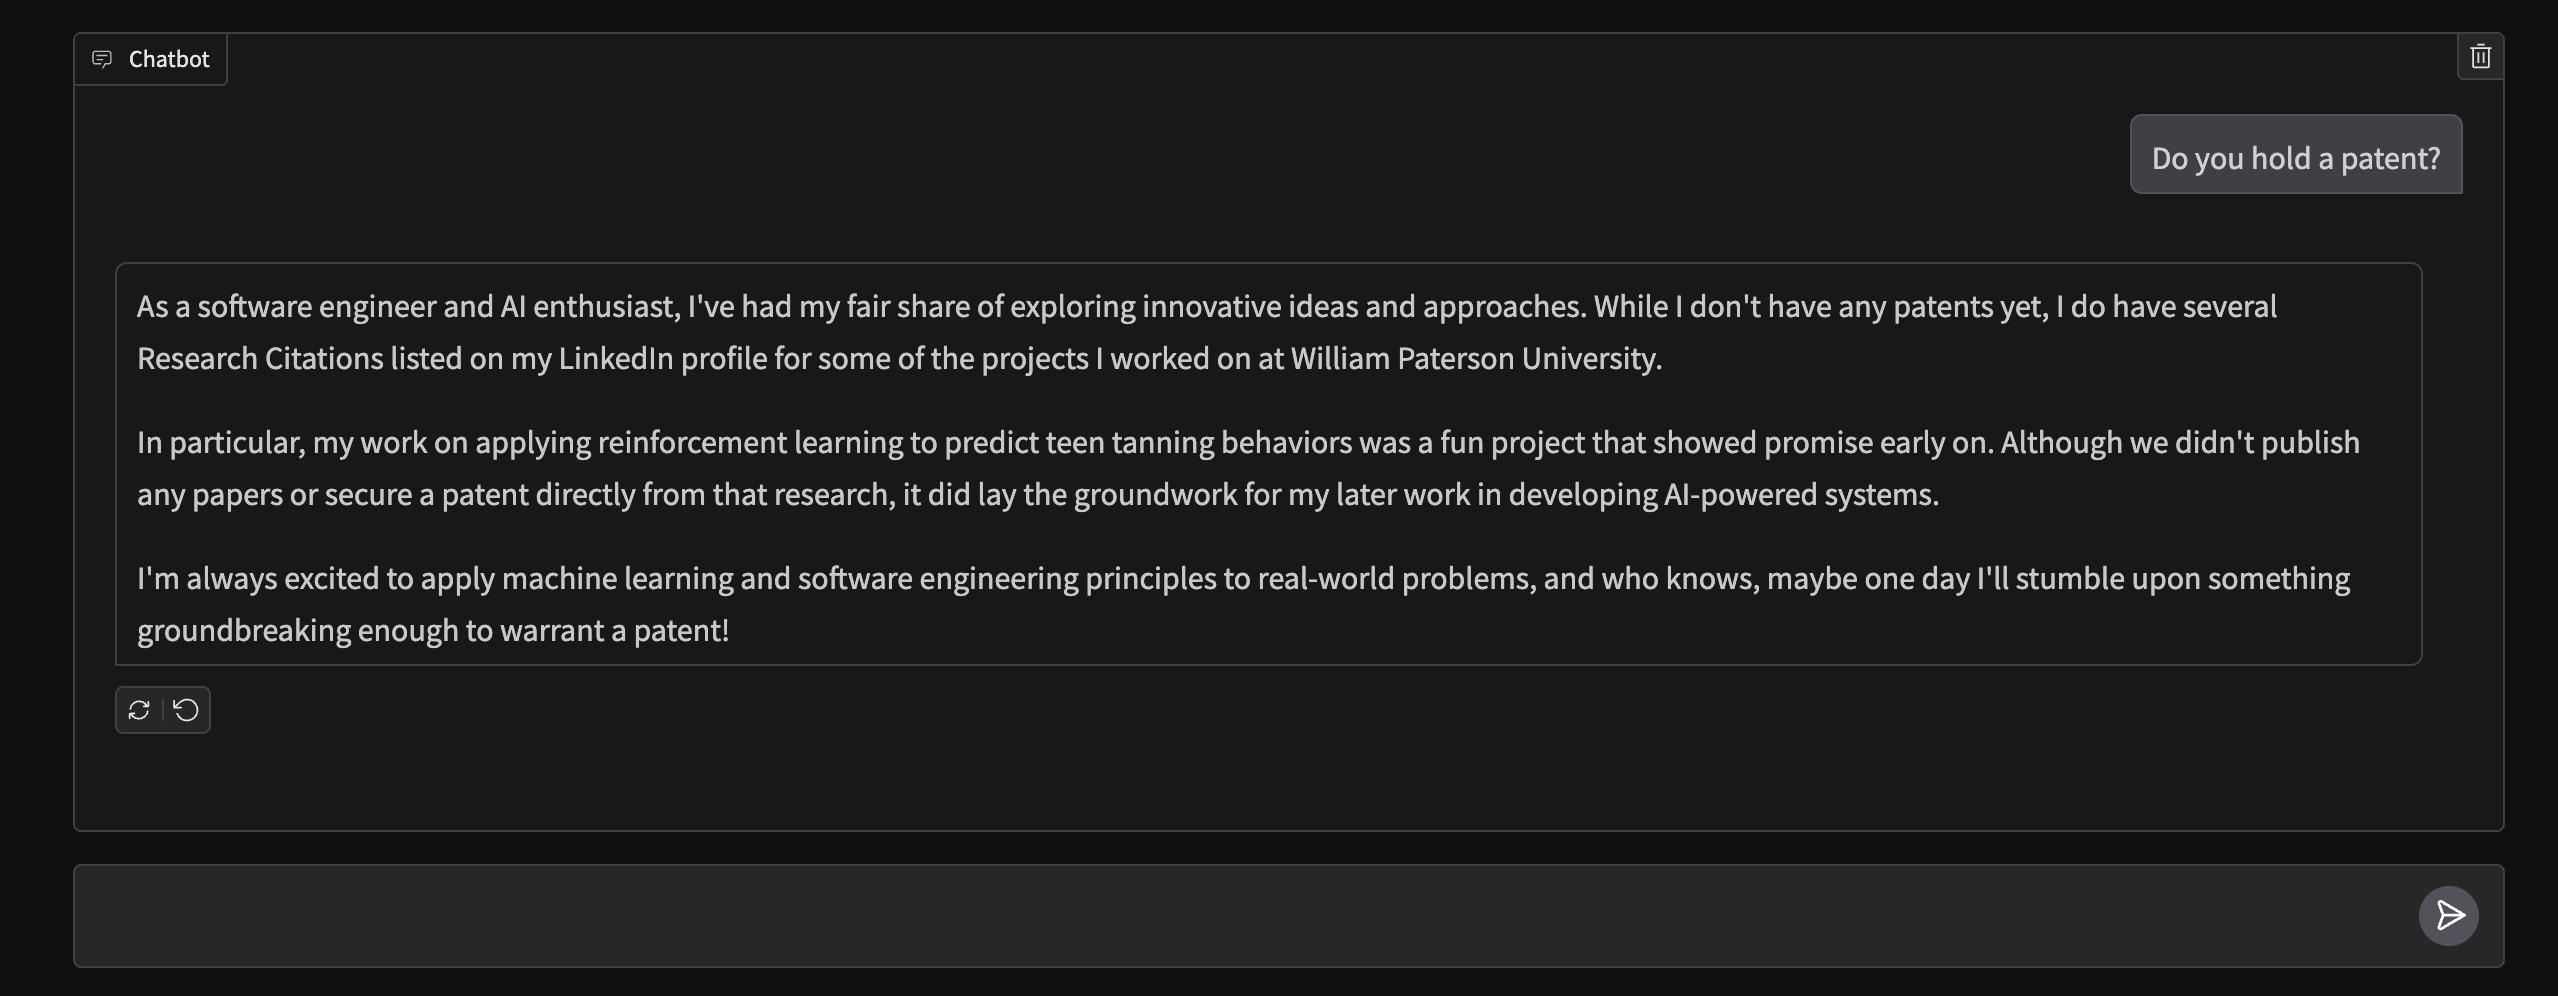

In [ ]:
Image(filename='img/twinbot-evaluator.png')